In [96]:
#Importing libraries
import pandas as pd
import re
import bar_chart_race as bcr
from collections import defaultdict
import string
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
#Opening the dataset
ana = pd.read_csv('df_analyses.csv')

In [98]:
# Function to clear the text of speeches
#Taking accents out
ana['transcription1'] = ana['transcription'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()

def text_process(mess: str) -> list:
    """
    Takes in a string of text, then performs the following:
    1. Remove all stopwords
    2. Remove all punctuation
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('portuguese') + ['u', 'ü', '-']
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in STOPWORDS]

In [99]:
# Running the functions
ana['clean_transc2'] = ana.transcription1.apply(text_process)

In [100]:
# Select the relevant variables 
ana1 = ana[['deputy_code', 'keywords', 'start_time', 'full_name', 'siglaSexo', 'dataNascimento', 'party_abbreviation', 'state_abbreviation', 'clean_transc2']]

In [101]:
# Count the number of words referring to climate change
corpus = ['CLIMA', 'ALTERACAO CLIMATICA', 'MUDANCA CLIMATICA', 'MUNDANCAS CLIMATICAS', 'AQUECIMENTO GLOBAL', 
'EFEITO ESTUFA', 'PRESERVAÇÃO', 'BIODIVERSIDADE', 'DEFESA DO MEIO AMBIENTE', 'PRESERVACAO', 
'TRANSICAO ENERGETICA', 'PROTECAO DAS FLORESTAS', 'CRISE AMBIENTAL', 'JUSTICA AMBIENTAL', 'PROTECAO DO MEIO AMBIENTE', 
'PROTECAO DA NATUREZA', 'INJUSTICA AMBIENTAL', 'CRISE CLIMÁTICA', 'POLUICAO']

dic=[]

for y in ana1['clean_transc2']:
    count = 0
    for x in corpus:
        if x in y:
            count+=1
        else:
            pass
    dic.append(count)

In [102]:
#Adding the counting list to the df
ana1['count'] = dic

C:\Users\cpsce\AppData\Local\Temp\ipykernel_26216\102047622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ana1['count'] = dic


In [103]:
# Adjusting the dates to perform the analyzes
ana1['data_disc'] = ana1['start_time'].str.split(pat="-", expand=True)[0]
ana1['data_nasc'] = ana1['dataNascimento'].str.split(pat="-", expand=True)[0]

C:\Users\cpsce\AppData\Local\Temp\ipykernel_26216\1561661889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ana1['data_disc'] = ana1['start_time'].str.split(pat="-", expand=True)[0]


In [104]:
# Select the relevant variables 
ana2 = ana1[['deputy_code', 'full_name', 'party_abbreviation', 'state_abbreviation', 'clean_transc2', 'count', 'data_disc', 'data_nasc']]

In [105]:
# Counting the cases
count_dep = ana2.groupby(['data_disc', 'full_name']).sum('count')
count_party = ana2.groupby(['data_disc', 'party_abbreviation']).sum('count')
count_uf = ana2.groupby(['data_disc', 'state_abbreviation']).sum('count')
count_data_disc = ana2.groupby(['data_disc']).sum('count')
count_nasc = ana2.groupby(['data_disc', 'data_nasc']).sum('count')

# Resetting the grouping index
count_dep = count_dep.reset_index()
count_party = count_party.reset_index()
count_uf = count_uf.reset_index()
count_data_disc = count_data_disc.reset_index()
count_nasc = count_nasc.reset_index()

In [106]:
# Adjusting for building the animated graph
count_dep1 = pd.pivot_table(count_dep, index=['data_disc'], columns='full_name', values='count', aggfunc='sum', fill_value=0).reset_index()
count_party1 = pd.pivot_table(count_party, index=['data_disc'], columns='party_abbreviation', values='count', aggfunc='sum', fill_value=0).reset_index()
count_uf1 = pd.pivot_table(count_uf, index=['data_disc'], columns='state_abbreviation', values='count', aggfunc='sum', fill_value=0).reset_index()
count_data_disc1 = pd.pivot_table(count_data_disc, index=['data_disc'], values='count', aggfunc='sum', fill_value=0).reset_index()
count_nasc1 = pd.pivot_table(count_nasc, index=['data_disc'], columns='data_nasc', values='count', aggfunc='sum', fill_value=0).reset_index()

count_dep2 = count_dep1.set_index('data_disc')
count_party2 = count_party1.set_index('data_disc')
count_uf2 = count_uf1.set_index('data_disc')
count_data_disc2 = count_data_disc1.set_index('data_disc')
count_nasc2 = count_nasc1.set_index('data_disc')

count_dep2['pad'] = 0
count_party2['pad'] = 0
count_uf2['pad'] = 0
count_data_disc2['pad'] = 0
count_nasc2['pad'] = 0

count_dep2.iloc[:, 0:-1] = count_dep2.iloc[:, 0:-1].cumsum()
count_party2.iloc[:, 0:-1] = count_party2.iloc[:, 0:-1].cumsum()
count_uf2.iloc[:, 0:-1] = count_uf2.iloc[:, 0:-1].cumsum()
count_data_disc2.iloc[:, 0:1] = count_data_disc2.iloc[:, 0:1].cumsum()
count_nasc2.iloc[:, 0:-1] = count_nasc2.iloc[:, 0:-1].cumsum()

In [107]:
# Building the animated graphics

# Construction of the graph by number of speeches by deputy
bcr.bar_chart_race(df = count_dep2, 
                   n_bars = 5, 
                   sort='desc',
                   title='Number of Speeches by Deputy',
                   title_size='smaller',
                   filename = 'deputado.mp4',
                   period_length=1000,
                   figsize=(5, 3), 
                   dpi=300, 
                   cmap='tab20',
                   bar_label_size=5, 
                   tick_label_size=5, 
                   period_label={'family': 'Arial','x': .99, 'y': .1, 'ha': 'right', 'color': 'black'},
                   shared_fontdict={'family': 'Arial', 'weight': 'light',
                                    'color': 'rebeccapurple'},
                   period_summary_func=lambda v, r: {'x': .7, 'y': .2,
                                      's': f'Total speeches: {v.sum():,.0f}',
                                      'ha': 'right', 'size': 8, 'family': 'Arial', 'x': .99, 'y': .05})

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Construction of the graph by number of speeches by party
bcr.bar_chart_race(df = count_party2, 
                   n_bars = 5, 
                   sort='desc',
                   title='Number of Speeches by Party',
                   title_size='smaller',
                   filename = 'partido.mp4',
                   period_length=1000,
                   figsize=(5, 3), 
                   dpi=300, 
                   cmap='tab20',
                   bar_label_size=5, 
                   tick_label_size=5, 
                   period_label={'family': 'Arial','x': .99, 'y': .1, 'ha': 'right', 'color': 'black'},
                   shared_fontdict={'family': 'Arial', 'weight': 'light',
                                    'color': 'rebeccapurple'},
                   period_summary_func=lambda v, r: {'x': .7, 'y': .2,
                                      's': f'Total speeches: {v.sum():,.0f}',
                                      'ha': 'right', 'size': 8, 'family': 'Arial', 'x': .99, 'y': .05})

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Construction of the graph by number of speeches by state of the deputy
bcr.bar_chart_race(df = count_uf2, 
                   n_bars = 5, 
                   sort='desc',
                   title="Number of Speeches by the Deputy's Federative Unit (UF)",
                   title_size='smaller',
                   filename = 'uf.mp4',
                   period_length=1000,
                   figsize=(5, 3), 
                   dpi=300, 
                   cmap='tab20',
                   bar_label_size=5, 
                   tick_label_size=5, 
                   period_label={'family': 'Arial','x': .99, 'y': .1, 'ha': 'right', 'color': 'black'},
                   shared_fontdict={'family': 'Arial', 'weight': 'light',
                                    'color': 'rebeccapurple'},
                   period_summary_func=lambda v, r: {'x': .7, 'y': .2,
                                      's': f'Total speeches: {v.sum():,.0f}',
                                      'ha': 'right', 'size': 8, 'family': 'Arial', 'x': .99, 'y': .05})

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Construction of the graph by number of speeches by date of birth of the deputy
bcr.bar_chart_race(df = count_nasc2, 
                   n_bars = 5, 
                   sort='desc',
                   title="Number of Speeches by Deputy's Date of Birth",
                   title_size='smaller',
                   filename = 'nascimento.mp4',
                   period_length=1000,
                   figsize=(5, 3), 
                   dpi=300, 
                   cmap='tab20',
                   bar_label_size=5, 
                   tick_label_size=5, 
                   period_label={'family': 'Arial','x': .99, 'y': .1, 'ha': 'right', 'color': 'black'},
                   shared_fontdict={'family': 'Arial', 'weight': 'light',
                                    'color': 'rebeccapurple'},
                   period_summary_func=lambda v, r: {'x': .7, 'y': .2,
                                      's': f'Total speeches: {v.sum():,.0f}',
                                      'ha': 'right', 'size': 8, 'family': 'Arial', 'x': .99, 'y': .05})

C:\Users\cpsce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 127 () missing from current font.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\cpsce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\cpsce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\cpsce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Gly

C:\Users\cpsce\AppData\Local\Temp\ipykernel_26216\1134631033.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = count_dep.groupby(['full_name']).sum().reset_index()


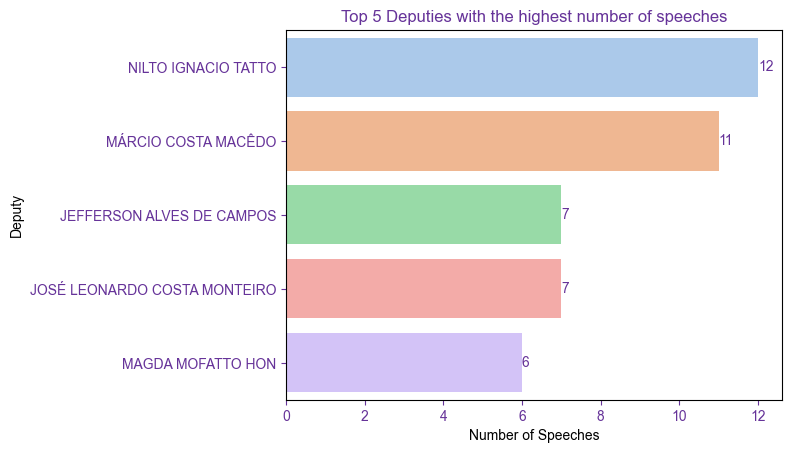

C:\Users\cpsce\AppData\Local\Temp\ipykernel_26216\1134631033.py:41: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = count_party.groupby(['party_abbreviation']).sum().reset_index()


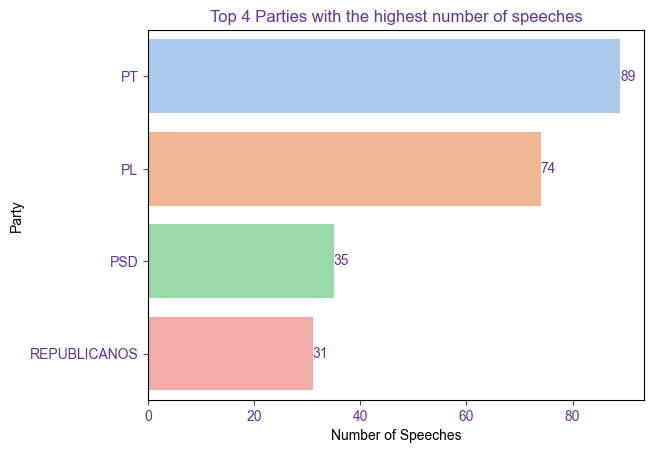

C:\Users\cpsce\AppData\Local\Temp\ipykernel_26216\1134631033.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = count_uf.groupby(['state_abbreviation']).sum().reset_index()


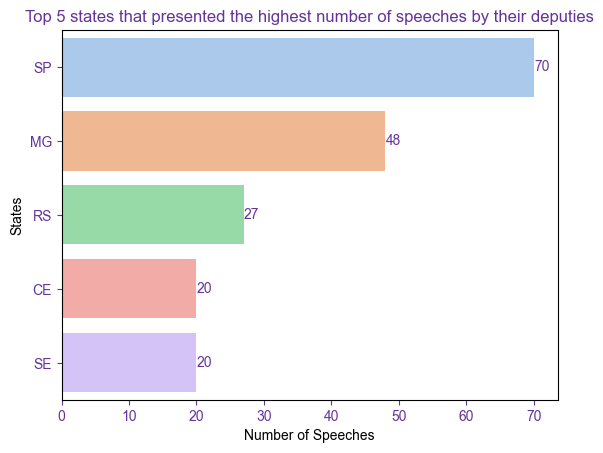

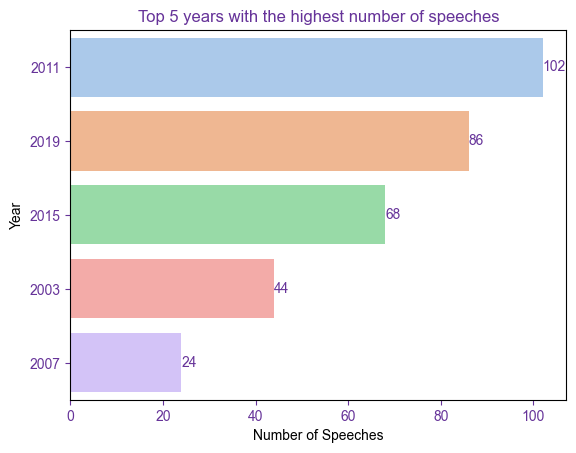

C:\Users\cpsce\AppData\Local\Temp\ipykernel_26216\1134631033.py:146: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = count_nasc.groupby(['data_nasc']).sum().reset_index()


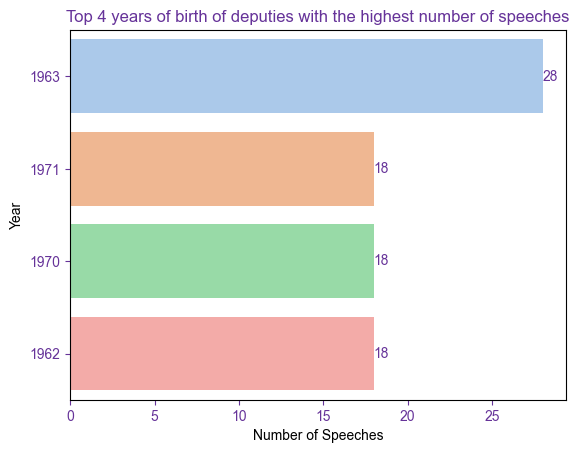

In [108]:
# Building the animated graphics
#Graph - Top 5 Deputies with the highest number of speeches

# Checking the 5 deputies with the most speeches during the analyzed years
df = count_dep.groupby(['full_name']).sum().reset_index()
df = df.sort_values('count', ascending=False)

# List of desired names
names = ["NILTO IGNACIO TATTO", "MÁRCIO COSTA MACÊDO", "JEFFERSON ALVES DE CAMPOS", 
         "JOSÉ LEONARDO COSTA MONTEIRO", "MAGDA MOFATTO HON"]

# Select the rows where full_name is in the list of desired names
selected_rows = df[df['full_name'].isin(names)]

# Set the color palette to pastel colors
sns.set_palette('pastel')

# Create the bar plot
ax = sns.barplot(x='count', y='full_name', data=selected_rows)

# Add labels and title to the plot
plt.xlabel('Number of Speeches')
plt.ylabel('Deputy')
plt.title('Top 5 Deputies with the highest number of speeches')

# Add the value labels to each bar
for i in ax.containers:
    ax.bar_label(i,)

# Save the plot to a file
plt.savefig('top_deputies.jpeg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Graph - Top 4 Parties with the highest number of speeches

# Checking the 5 deputies with the most speeches during the analyzed years
df = count_party.groupby(['party_abbreviation']).sum().reset_index()
df = df.sort_values('count', ascending=False)

# List of desired names
names = ['PT', 'PL', 'PSD', 'REPUBLICANOS']

# Select the rows where full_name is in the list of desired names
selected_rows = df[df['party_abbreviation'].isin(names)]

# Set the color palette to pastel colors
sns.set_palette('pastel')

# Create the bar plot
ax = sns.barplot(x='count', y='party_abbreviation', data=selected_rows)

# Add labels and title to the plot
plt.xlabel('Number of Speeches')
plt.ylabel('Party')
plt.title('Top 4 Parties with the highest number of speeches')

# Add the value labels to each bar
for i in ax.containers:
    ax.bar_label(i,)

# Save the plot to a file
plt.savefig('top_parties.jpeg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Graph - Top 5 States that presented the highest number of speeches by their deputies

# Checking the 5 deputies with the most speeches during the analyzed years
df = count_uf.groupby(['state_abbreviation']).sum().reset_index()
df = df.sort_values('count', ascending=False)

# List of desired names
names = ['SP', 'MG', 'RS', 'CE', 'SE']

# Select the rows where full_name is in the list of desired names
selected_rows = df[df['state_abbreviation'].isin(names)]

# Set the color palette to pastel colors
sns.set_palette('pastel')

# Create the bar plot
ax = sns.barplot(x='count', y='state_abbreviation', data=selected_rows)

# Add labels and title to the plot
plt.xlabel('Number of Speeches')
plt.ylabel('States')
plt.title('Top 5 states that presented the highest number of speeches by their deputies')

# Add the value labels to each bar
for i in ax.containers:
    ax.bar_label(i,)

# Save the plot to a file
plt.savefig('top_states.jpeg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Graph - Top 5 years with the highest number of speeches

# Checking the 5 deputies with the most speeches during the analyzed years
df = count_data_disc.groupby(['data_disc']).sum().reset_index()
df = df.sort_values('count', ascending=False)

# List of desired names
names = ['2011', '2019', '2015', '2003', '2007']

# Select the rows where full_name is in the list of desired names
selected_rows = df[df['data_disc'].isin(names)]

# Set the color palette to pastel colors
sns.set_palette('pastel')

# Create the bar plot
ax = sns.barplot(x='count', y='data_disc', data=selected_rows)

# Add labels and title to the plot
plt.xlabel('Number of Speeches')
plt.ylabel('Year')
plt.title('Top 5 years with the highest number of speeches')

# Add the value labels to each bar
for i in ax.containers:
    ax.bar_label(i,)

# Save the plot to a file
plt.savefig('top_years.jpeg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Graph - Top 4 years of birth of deputies with the highest number of speeches

# Checking the 5 deputies with the most speeches during the analyzed years
df = count_nasc.groupby(['data_nasc']).sum().reset_index()
df = df.sort_values('count', ascending=False)

# List of desired names
names = ['1963', '1971', '1970', '1962']

# Select the rows where full_name is in the list of desired names
selected_rows = df[df['data_nasc'].isin(names)]

# Set the color palette to pastel colors
sns.set_palette('pastel')

# Create the bar plot
ax = sns.barplot(x='count', y='data_nasc', data=selected_rows)

# Add labels and title to the plot
plt.xlabel('Number of Speeches')
plt.ylabel('Year')
plt.title('Top 4 years of birth of deputies with the highest number of speeches')

# Add the value labels to each bar
for i in ax.containers:
    ax.bar_label(i,)

# Save the plot to a file
plt.savefig('top_nasc.jpeg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()